# 3. Robot motion

Index:
- [3.1 Pose composition](#pose_composition)
- [3.2 Movement of a robot using velocity command](#velocity_commands)
- [3.3 Movement of a robot using odometry commands](#odometry_commands)


## Introduction

A fundamental aspect of the development of mobile robots is the motion itself. This is not a trivial matter as it is one of the main sources of uncertainty and other constraints to the movement difficult its implementation.
This particular lesson introduces the concept of a robot's pose and how we deal with it in a probabilistic context.

The pose itself can take multiple forms depending on the problems context:

- **2D location**: In a planar context we only need to a 2d vector $[x, y]^T$ to locate a robot against a point of reference, the origin $(0, 0).$
- **2D pose**: In most cases involving mobile robots, the location alone is insufficient. We need an aditional paramater known as orientation or *bearing*. Therefore, a robot's pose is usually expressed as $[x, y, \theta]^T$. *In the rest of the course, we mostly refer to this one.*
- **3D pose**: Although we will only mentioned in passing, for robotics applications in the 3D space, *i.e.* UAV or drones, not only a third axis $z$ is added, but to handle the orientation in a 3D environment we need 3 components, *i.e.* roll, pitch and yaw. This course is centered around planar movile robots so we will not use this one, nevertheless most methods could be adapted to 3D environments.

In [30]:
%matplotlib notebook

# IMPORTS
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

from utils.DrawRobot import DrawRobot
from utils.tcomp import tcomp

## <span style="color:green">OPTIONAL</span>

<span style="color:green">In the Robot motion lecture, we started talking about *Differential drive* motion systems. Include as many cells as needed to introduce the background that you find interesting about it and some code illustrating some related aspect, for example, a code computing and plotting the *Instantaneus Center of Rotation (ICR)* according to a number of given parameters.</span>

## 3.1 Pose composition <a id="pose_composition"></a>

Given an initial pose $p_1$ and a pose differential $\Delta p$, *i.e.* how much the robot has moved during an interval of time, we compute the final pose $p$ using the **composition of poses** function:

$$
    p_1 = 
        \begin{bmatrix}
            x_1 \\ y_1 \\ \theta_1
        \end{bmatrix},
    \Delta p = 
        \begin{bmatrix}
            \Delta x \\ \Delta y \\ \Delta \theta
        \end{bmatrix}
$$

$$
    \begin{equation}
    p = \begin{bmatrix}
            x \\ y \\ \theta
        \end{bmatrix}
        = p_1 \oplus \Delta p
        = \begin{bmatrix}
            x_1 + \Delta x \cos \theta_1 - \Delta y \sin \theta_1 \\ 
            y_1 + \Delta x \sin \theta_1 - \Delta y \cos \theta_1 \\
            \theta_1 + \Delta \theta
          \end{bmatrix}
    \end{equation}
$$


The differential $\Delta p$, although we are using it as control in this exercise, normally is calculated given the robot's locomotion or sensed by the wheel encoders.

## <span style="color:green">OPTIONAL</span>

<span style="color:green">Implement your own methods to compute the composition of two poses, as well as the inverse composition. Include some examples of their utilization, also incorporating plots.</span>

**Assignment**

Take a look at the `Robot()` class provided and its methods. Then, modify the main function in the next cell for the robot to describe a $8m \times 8m$ square path as seen in the figure below.

The robot starts in the bottom-left corner $(0, 0)$ heading north and moves at increments of $2 m$ each step. Each 4 steps it will turn right.

**Example**


<figure style="text-align:center">
  <img src="images/fig3-1-1.png" alt="">
  <figcaption>Fig. 1: Route of our robot.</figcaption>
</figure>

In [2]:
class Robot():
    '''Mobile robot implementation
    
        Attr:
            pose: Expected position of the robot
    '''
    def __init__(self, mean):
        self.pose = mean

    def step(self, u):
        self.pose = tcomp(self.pose, u)
    
    def draw(self, fig, ax):
        DrawRobot(fig, ax, self.pose)

In [3]:
def main(robot):
    
    # PARAMETERS INITIALIZATION
    num_steps = 15 # Number of robot motions
    turning = 4  # Number of steps for turning
    u = np.vstack([2., 0., 0.]) # Motion command (pose increment)
    angle_inc = -np.pi/2 # Angle increment
    
    # VISUALIZATION
    fig, ax = plt.subplots()
    plt.ion()
    plt.draw()
    plt.xlim((-2, 10))
    plt.ylim((-2, 10))
    
    plt.grid()
    robot.draw(fig, ax)
    
    # MAIN LOOP
    for step in range(1,num_steps+1):
        
        # Check if the robot has to move in straight line or also has to turn
        # and accordingly set the third component (rotation) of the motion command 
        if not (step%turning==0):
            u[2] = 0
        else:
            u[2] = -np.pi/2
             
        # Execute the motion command        
        robot.step(u)
        
        # VISUALIZATION
        robot.draw(fig, ax)
        fig.canvas.draw()
        plt.pause(0.1)   

<IPython.core.display.Javascript object>


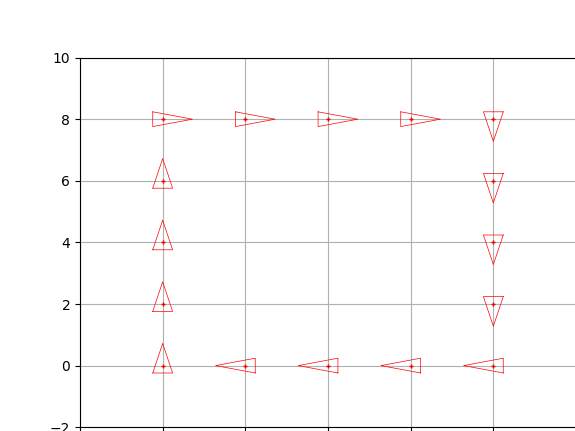

In [4]:
# RUN 
initial_pose = np.vstack([0., 0., np.pi/2])
robot = Robot(initial_pose)
main(robot)

### 3.1.1 Considering noise

In the previous case, the robot motion was error-free, this is overly optimistic as in a real use case the conditions of the environment are a huge source of uncertainty.

Therefore, we have to transform the movement of the robot into a (multidimensional) gaussian distribution.

- The mean is still the pose differential in the previous exercise.
- The covariance is a $3 \times 3$ matrix, which defines the amount of error at each step (time interval) 

**Assignment**

Now, we are goint to add a Gaussian noise to the motion, assuming that the incremental motion now follows the probability distribution:

$$
    \Delta p = N(\Delta p_{given}, \Sigma_{\Delta p})
    \textit{ with } 
    \Sigma_{\Delta p}  =
        \begin{bmatrix}
            0.04 & 0 & 0 \\
            0 & 0.04 & 0 \\
            0 & 0 & 0.01
        \end{bmatrix}
    (\text{ units in }m^2 \text{ and } rad^2)
$$

For doing that, complete the `NosyRobot()`, which is a child class of the previous `Robot()` one. Concretely, you have to:

- Complete this new class by adding some amount of noise to the movement (take a look at the `step()` method. *Hints: [`np.vstack()`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.vstack.html), `multivariate_normal.rvs()`*
- Along with the expected pose drawn in red (`self.pose`), in the `draw()` method plot the real pose of the robot (`self.true_pose`) in blue, which is affected by noise. 

Run the cell several times to see that the motion (and the path) is different each time. Try also with different values of the covariance matrix.

**Example**

<figure style="text-align:center">
  <img src="images/fig3-1-2.png" alt="">
  <figcaption>Fig. 2: Movement of our robot using pose compositions. <br/>
      Containing the expected poses (in red) and the true pose <br/> affected by noise (in blue)</figcaption>
</figure>

In [39]:
class NoisyRobot(Robot):
    """Mobile robot implementation. It's motion has a set ammount of noise.
    
        Attr:
            pose: Inherited from Robot
            true_pose: Real robot pose, which has been affected by some ammount of noise.
            covariance: Amount of error of each step.
    """
    def __init__(self, mean, covariance):
        super().__init__(mean)
        self.true_pose = mean
        self.covariance = covariance
        
    def step(self, step_increment):
        """Computes a single step of our noisy robot.
        
            super().step(...) updates the expected pose (without noise)
            Generate a noisy increment based on step_increment and self.covariance.
            Then this noisy increment is applied to self.true_pose
        """
        super().step(step_increment)
        true_step = stats.multivariate_normal.rvs(step.increment.flatten(), step.covariance).rvs.reshape(-1,1)
        self.true_pose = tcomp(self.pose, true_step)
        
    def draw(self, fig, ax):
        super().draw(fig, ax)
        DrawRobot(fig, ax, self.pose, 'blue')

In [40]:
# RUN 
initial_pose = np.vstack([0., 0., np.pi/2])
cov = np.diag([0.04, 0.04, 0.01])  

robot = NoisyRobot(initial_pose, cov)
main(robot)

TypeError: main() missing 1 required positional argument: 'nSteps'

# 3.2 Movement of a robot using velocity commands <a id='velocity_commands'></a>

In the remaining assignments related to robot motion we will describe two probabilistic motion models for planar movement. The **velocity motion model** and the **odometry motion model**, the former being the main topic of this assignment.

The *velocity motion model* is mainly used for motion planning, where the details of the robot's movement are of importance and odometry information is not available (it is computed after the movement).

This motion model is characterized by the use of two velocities to control the robot's movement: **linear velocity** $v$ and **angular velocity** $w$. Therefore, during the following exercises, the movement commands will be of the form: $$u = \begin{bmatrix} v \\ w \end{bmatrix}$$

Concretely, this motion model is characterized by the following equations:
<table>
    <tr>
        <td>

- If $w \neq 0$:

    $$
        x_t = x_{t-1} + 
        \begin{bmatrix}
            -R \sin \theta_{t-1} + + R \sin(\theta_{t-1} + \Delta \theta) \\ 
            R \cos \theta_{t-1} - R \cos(\theta_{t-1} + \Delta \theta)\\
            \Delta \theta
        \end{bmatrix}
    $$

- If $w = 0$:

    $$
        x_t = x_{t-1} + v \cdot \partial t
        \begin{bmatrix}
            \cos \theta_{t-1} \\ \sin \theta_{t-1} \\ 0
        \end{bmatrix}
    $$
    <td/>       
    <td>
        $$ 
        \begin{aligned}
        v &= w \cdot R \\
        \Delta \theta &= w \cdot  \partial t
        \end{aligned}
        $$
    <td/>
  <tr/>
<table/>

In [31]:
# IMPORTS
from numpy import random

from utils.PlotEllipse import PlotEllipse

### 3.2.1 The model in action   


**Assignment**

Modify the following `next_pose()` function, used in the `VelocityRobot` class below, which computes the next pose of a robot given its previous pose $x$, the velocity movement command $u=[v,w]'$, and a lapse of time $dt$. Concretly you have to complete the if-else statement that takes into account when the robot moves in an straight line ($w = 0$). *Note: you don't have to modify the `None` in the function header nor in the `if cov is not None:` condition*

At this point we don't take into account uncertainty in the system: neither from the initial pose (matrix $P_{3\times3}$) nor the movement $(v, w)$ (matrix $Q_{2\times2}$).

**Example**

<figure style="text-align:center">
  <img src="images/fig3-2-1.png" alt="">
  <figcaption>Fig. 1: Route of our robot.</figcaption>
</figure>

In [33]:
def next_pose(x, u, dt, cov=None):
    ''' This function takes pose x and transform it according to the motion u=[v,w]'
        applying the differential drive model.

        Args:
            x: current pose
            u: differential command as a vector [v, w]'
            dt: Time interval in which the movement occurs
            cov: covariance of our movement. If not None, then add gaussian noise
    '''
    if cov is not None:
        u += cov @ random.randn(2, 1)

    if u[1] == 0: #linear motion w=0
        next_x = np.vstack([np.cos(x[2]),
                           np.sin(x[2]),
                           0])
    else: #Non-linear motion w=!0
        R = u[0]/u[1] #v/w=r is the curvature radius
        next_x = np.vstack([-R*np.sin(x[2])+R*np.sin(x[2]-(u[1]*dt)),
                           R*np.cos(x[2])-R*np.cos(x[2]-(u[1]*dt)),
                           u[1]*dt])

    return next_x

In [27]:
class VelocityRobot(object):
    """ Mobile robot implementation that uses velocity commands.
    
        Attr:
            pose: expected pose of the robot in the real world (without taking account noise)
            dt: Duration of each step in seconds
    """    
    def __init__(self, mean, dt):
        self.pose = mean
        self.dt = dt
        
    def step(self, u):
        self.pose = next_pose(self.pose, u, self.dt)
        
    def draw(self, fig, ax):
        DrawRobot(fig, ax, self.pose)

Test the movement of your robot using the demo below.

In [28]:
def main(robot, nSteps):
          
    v = 1 # Linear Velocity 
    l = 0.5 #Half the width of the robot
        
    # MATPLOTLIB
    fig, ax = plt.subplots()
    plt.ion()
    fig.canvas.draw()
    plt.xlim((-2, 20))
    plt.ylim((-2, 30))
    
    plt.grid()
        
    # MAIN LOOP
    for k in range(1, nSteps + 1):
        #control is a wiggle with constant linear velocity
        u = np.vstack((v, np.pi / 10 * np.sin(4 * np.pi * k/nSteps)))
        
        robot.step(u)   
        
        #draw occasionally
        if (k-1)%20 == 0:
            robot.draw(fig, ax)
            fig.canvas.draw()
            plt.pause(0.1)

<IPython.core.display.Javascript object>


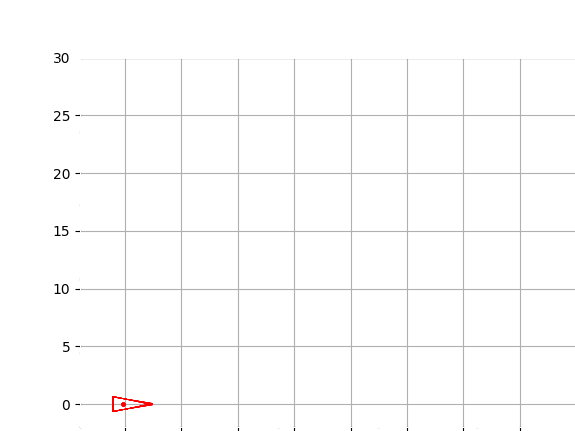

In [34]:
# RUN 
dT = 0.1 # time steps size
pose = np.vstack([0., 0., 0.])

robot = VelocityRobot(pose, dT)
main(robot, nSteps=400)

### 3.2.2 Adding uncertainty

Now we will include uncertainty to the previous exercise, changing the behaviour of the robot class you have implemented.

In contrast to the noisy robot in practice 3.1, we will use the equations of the velocity motion model and their respective Jacobians to keep track of how confident we are of the robot's pose (i.e. the robot's pose now is also a gaussian distribution).

Therefore, we have to deal with two Gaussian distributions: 
- the **pose** $\sim(x_t, \Sigma_{x_t})$ at time $t$,
- and the **movement command** $\sim(u_t, \Sigma_{u_t})$, being applied during an interval of time $\partial t$.

The covariance of this movement ($\Sigma_{u_t}$,`Q` in the code) is defined as seen below. It is constant throughout the execution of our code:

$$
    \Sigma_{u_t} = \begin{bmatrix}
            \sigma_v^2 & 0 \\
            0 &  \sigma_w^2
        \end{bmatrix}
$$

Whereas, the pose's covariance $\Sigma_{x_t}$ (`P_t` in the code) has to be updated at every step of the execution. To achieve this you'll have to use:

$$\Sigma_{x_t} =  \frac{\partial g}{\partial x_{t-1}} \cdot \Sigma_{x_{t-1}} \cdot {\frac{\partial g}{\partial x_{t-1}}}^T + \frac{\partial g}{\partial u_{t}} \cdot \Sigma_{u_t} \cdot {\frac{\partial g}{\partial u_{t}}}^T$$
 
Where $\partial g / \partial x_{t-1}$ and $\partial g / \partial u_{t}$ (`JacF_x` and `JacF_u` in the code) are the jacobians of our motion model evaluated at the previous pose $x_{t-1}$ and the current action $u_t$.

As a practical exercise, you can derivate the ecuations of these jacobians and check them against the solution in the apendix of the slides.

## <span style="color:green">OPTIONAL</span>

<span style="color:green">Write a Markdown cell containing the Jacobians ecuations aforementioned.</span>

**Assignment**
      
1. Complete the following code: calculating the covariance matrix $P_k$ and then draw them as ellipses.
 

 
**Example**
 
<figure style="text-align:center">
  <img src="images/fig3-2-2.png" alt="">
  <figcaption>Fig. 2: Movement of a robot using velocity commands. <br/> Representing the expected pose (in red), the true pose (as dots) <br/> and the confidence ellipse.</figcaption>
</figure>

In [ ]:
def next_covariance(x, P, Q, u, dt):
    ''' Compute the covariance of a robot following the velocity motion model

        Args:
            x: current pose (before movement)
            u: differential command as a vector [v, w]''
            dt: Time interval in which the movement occurs
            P: current covariance of the pose
            Q: covariance of our movement.
    '''
    # Aliases
    v = u[0, 0]
    w = u[1, 0]

    sx, cx = np.sin(x[2, 0]), np.cos(x[2, 0]) #sin and cos for the previous robot heading
    si, ci = np.sin(u[1, 0]*dt), np.cos(u[1, 0]*dt) #sin and cos for the heading increment
    R = u[0, 0]/u[1, 0] #v/w Curvature radius

    if u[1, 0] == 0:  #linear motion w=0 --> R = infinite
        #TODO JACOBIAN HERE
        JacF_x = np.array([
            None,
            None,
            None
        ])
        JacF_u = np.array([
            None,
            None
        ])
    else: #Non-linear motion w=!0
        # TODO JACOBIAN HERE
        JacF_x = np.array([
            None,
            None,
            None
        ])

        JacF_u = (
            np.array([
                None,
                None,
                None
            ])@
            np.array([
                [1/w, -v/w**2],
                [0, dt]
            ])
        )
    #prediction steps
    Pt = ( None @ None @ None ) + ( None @ None @ None )
    
    return Pt

2. Complete the methods:

  - `step` to get the true robot pose (ground-truth) using the $Q$ matrix, 
  - and the `draw()` one to plot an ellipse representing the uncertainty about the robot pose centered at the expected robot pose (`self.pose`) as well as marks representing the ground truth poses. 

In [ ]:
class NoisyVelocityRobot(VelocityRobot):
    """ Mobile robot implementation that uses velocity commands.
       
        Attr:
            [...]: Inherited from VelocityRobot
            true_pose: expected pose of the robot in the real world (noisy)
            cov_pose: Covariance of the pose at each step
            cov_move: Covariance of each movement. It is a constant

    """
    
    def __init__(self, mean, cov_pose, cov_move, dt):
        super().__init__(mean, dt)
        self.true_pose = mean
        self.cov_pose = cov_pose
        self.cov_move = cov_move
        
    def step(self, u):
        self.cov_pose = next_covariance(None, None, None, None, None)
        
        super().step(u)
        self.true_pose = next_pose(None, None, None, cov=None)
        
    def draw(self, fig, ax):
        super().draw(fig, ax)
        el = PlotEllipse(fig, ax, None, None)
        ax.plot(None, None, 'o', color=el[0].get_color())

In [ ]:
# RUN
dT = 0.1 # time steps size

SigmaV = 0.1 #Standard deviation of the linear velocity. 
SigmaW = 0.1 #Standard deviation of the angular velocity
nSteps = 400 #Number of motions

P = np.diag([0.2, 0.4, 0.]) #pose covariance matrix 3x3
Q = np.diag([SigmaV**2, SigmaW**2]) #motion covariance matrix 2x2

robot = NoisyVelocityRobot(np.vstack([0., 0., 0.]), P, Q, dT)
main(robot, nSteps=nSteps)

## 3.3. Movement of a robot using odometry commands <a id='odometry_commands'></a>

The *odometry motion model* is more suitable to keep track and estimate the robots pose in contrast to the *velocity model*. The reason being, most robot bases provide some form of *odometry information*, a measurement of how much the robot has moved in reality, whose greater precision makes it useful to keep track of the pose.

Although technically it is a measurement rather than a control, we 
treat it as control to simplify the modeling. The odometry commands take the form of:

$$
    u_t = \begin{bmatrix}
            \Delta x  \\
            \Delta y \\
            \Delta \theta
        \end{bmatrix}
$$

We'll implement this motion model in both analytical and sample form.

In [ ]:
# IMPORTS
from utils.pause import pause
from utils.Jacobians import J1, J2

### 3.3.1 Analytical form

Just as we did in lesson 3.1, the analytic form of the odometry motion model uses the composition of poses to model the robot's movement, providing only a notion of how much the pose has changed, not how did it get there.

$$
    p_1 \oplus \Delta p
    = \begin{bmatrix}
        x_1 + \Delta x \cos \theta_1 - \Delta y \sin \theta_1 \\ 
        y_1 + \Delta x \sin \theta_1 - \Delta y \cos \theta_1 \\
        \theta_1 + \Delta \theta
      \end{bmatrix}
$$

The crux of this assignment is to keep track of the covariance matrix of the pose $(P)$, using the Jacobians of this movement model.

**Assignment**

Similarly to the exercise 3.1, we'll move a robot along a 8-by-8 square (in meters), in increments of 2m. In this case you have to complete:

- The `step()` method to compute the new expected pose (`self.pose`), the new true pose (ground-truth `self.true_pose`) after adding some noise to the movement command $u$ according to `Q`, and to update the uncertainty about the robot position (covariance matrix `self-P`).
- The `draw()` method to plot the uncertainty of the pose (as an ellipse) and the true position (ground-truth).

We are going to consider the following motion covariance matrix (it is already coded for you):

$$
    \Sigma_{\Delta_p} = \begin{bmatrix}
        0.04 & 0 & 0 \\
        0 & 0.04 & 0 \\
        0 & 0 & 0.01
    \end{bmatrix}
$$

**Example**

<figure style="text-align:center">
  <img src="images/fig3-3-1.png" width="400" alt="">
  <figcaption>Fig. 1: Movement of a robot using odometry commands. <br/> Representing the expected pose (in red), the true pose (as dots) <br/> and the confidence ellipse.</figcaption>
</figure>

In [ ]:
class Robot():
    """ Simulation of a robot base
    
        Attrs:
            pose: Expected pose of the robot
            P: Covariance of the current pose
            true_pose: Real pose of the robot(affected by noise)
            Q: Covariance of the movement
    """
    def __init__(self, x, P, Q):
        self.pose = x
        self.P = P
        self.true_pose = self.pose
        self.Q = Q
        
    def step(self, u):
        # TODO Update expected pose
        self.pose = tcomp(self.pose, u)
        
        # TODO Generate true pose 
        noisy_u = np.vstack(stats.multivariate_normal.rvs(u.flatten(), self.Q))
        self.true_pose = tcomp(self.true_pose, noisy_u)
        
        # TODO Update covariance
        JacF_x = J1(self.pose, u)
        JacF_u = J2(self.pose, u)

        self.P = (
            (JacF_x @ self.P @ JacF_x.T) 
            + (JacF_u @ self.Q @ JacF_u.T)
        )
    
    def draw(self, fig, ax):
        DrawRobot(fig, ax, self.pose)
        el = PlotEllipse(fig, ax, self.pose, self.P)
        ax.plot(self.true_pose[0, 0], self.true_pose[1, 0], 'o', color=el[0].get_color())
  

In [ ]:
def demo_odometry_commands_analytical(robot):  
    # MATPLOTLIB
    fig, ax = plt.subplots()
    ax.set_xlim([-3, 11])
    ax.set_ylim([-3, 11])
    plt.ion()
    plt.grid()
    plt.tight_layout()
    fig.canvas.draw()
    
    # MOVEMENT PARAMETERS
    nSteps = 15
    ang = -np.pi/2 # angle to turn in corners
    u = np.vstack((2., 0., 0.))
    
    # MAIN LOOP
    for i in range(nSteps):
        # change angle on corners
        if i % 4 == 3:
            u[2, 0] = ang

        #Update positions
        robot.step(u)

        # Restore angle iff changed
        if i % 4 == 3:
            u[2, 0] = 0

        # Draw every loop
        robot.draw(fig, ax)
        fig.canvas.draw()
        plt.pause(0.3)

In [ ]:
x = np.vstack([0., 0., np.pi/2]) # pose inicial

# Probabilistic parameters
P = np.diag([0., 0., 0.])
Q = np.diag([0.04, 0.04, 0.01])

robot = Robot(x, P, Q)
demo_odometry_commands_analytical(robot)

### 3.3.2 Sample form

The analytical form used above, although useful for the probabilistic algorithms we will cover in this course, does not work well for sampling algorithms such as particle filters.

The reason being, if we generate random samples from the gaussian distributions generated in the previous exercise, we will find some poses that are not feasible to the non-holonomic movement of a robot, i.e. they do not correspond to a velocity command $(v, w)$ with noise.

The following *sample form* is a more realistic way to generate samples of the pose. Now we model the movement of the robot as a sequence of actions: 

1. **Turn** ($\theta_1$): to face the destination point.
2. **Advance** ($d$): to arrive at the destination.
3. **Turn** ($\theta_2$): to get to the desired angle.

So this type of order is expressed as:

$$
    u_t = \begin{bmatrix}
            \theta_1  \\
            d \\
            \theta_2
        \end{bmatrix}
$$

It can easily be generated from odometry poses $[\hat x_t, \hat y_t,\hat \theta_t]'$ and $[\hat x_{t-1}, \hat y_{t-1},\hat \theta_{t-1}]'$ given the following equations:

$$
    \begin{equation}
    \theta_1 =atan2(\hat y_t -\hat y_{t-1}, \hat x_t -\hat x_{t-1})- \hat \theta_{t-1} \\
    d = \sqrt{(\hat y_t -\hat y_{t-1})^2 + (\hat x_t -\hat x_{t-1})^2} \\
    \theta_2  = \hat{\theta}_t - \hat{\theta}_{t-1} - \theta_1
    \end{equation}
$$

**Assignment**

1. Implement a function that, given the previously mentioned $[\hat x_t, \hat y_t,\hat \theta_t]'$ and $[\hat x_{t-1}, \hat y_{t-1},\hat \theta_{t-1}]'$ generates an order $u_t = [ \theta_1, d , \theta_2 ]'$

In [ ]:
def generate_move(pose_now, pose_old):
    diff = pose_now - pose_old
    theta1 = np.arctan2(diff[1, 0], diff[0, 0]) - pose_old[2, 0]
    d = np.sqrt(diff[0, 0]**2 + diff[1, 0]**2)
    theta2 = diff[2, 0] - theta1
    return np.vstack((theta1, d, theta2))

In [ ]:
generate_move(np.vstack([0., 0., 0.]), np.vstack([1., 1., np.pi/2]))

  Expected output for the commented example:

  ```
  array([[-3.92699082],
       [ 1.41421356],
       [ 2.35619449]])
  ```

2. Using the resulting control action $u_t = [\hat \theta_1, \hat d, \hat \theta_2]'$ we can model the noise of the action in the following way:

  $$
    \begin{equation}
        \theta_1 = \hat\theta_1 + \text{sample}\left(\alpha_0 \hat\theta_1^2 + \alpha_1 \hat d^2 \right) \\
        d = \hat d + \text{sample}\left(\alpha_2 \hat d^2 + \alpha_3 \left(\hat\theta_1^2 + \hat d^2 \right) \right) \\
        \theta_2 = \hat\theta_2 + \text{sample}\left(\alpha_0 \hat\theta_2^2 + \alpha_1 \hat d^2\right)
    \end{equation}
  $$

  Where $sample(b)$ generates a random value from a distribution $N(0, b)$. The vector $\alpha = [\alpha_0, \dots, \alpha_3]$, models the robot's intrinsic noise.

  The pose of the robot at the end of the movement is computed as follows:

$$
    \begin{equation}
        x_t = x_{t-1} + d \cos\left(\theta_{t-1} + \theta_1 \right) \\
        y_t = y_{t-1} + d \sin\left(\theta_{t-1} + \theta_1 \right) \\
        \theta_t = \theta_{t-1} +  \theta_1 +  \theta_2
    \end{equation}
$$

Complete the `step()` and `draw()` methods to:
- Update the expected robot pose and generate new samples.
- Draw the true pose of the robot (without angle) as a cloud of particles (samples of possible points which the robot can be at). 

Play with different values of 'a'. To improve this visualization the robot will move in increments of $0.5$ and we are goint to plot the particles each 4 increments.

**Example**

<figure style="text-align:center">
  <img src="images/fig3-3-2.png" width="400" alt="">
  <figcaption>Fig. 1: Movement of a robot using odometry commands in sampling form. <br/> Representing the expected pose (in red) and the samples (as clouds of dots) </figcaption>
</figure>

In [ ]:
class SampledRobot(object):
    def __init__(self, mean, a, n_samples):
        self.pose = mean
        self.a = a
        self.samples = np.tile(mean, n_samples)
        
    def step(self, u):
        # TODO Update pose
        self.pose[0, 0] += None
        self.pose[1, 0] += None
        self.pose[2, 0] = None
                
        # TODO Generate new samples
        sample = lambda b: stats.norm(loc=0, scale=b).rvs(size=self.samples.shape[1])
        
        u2 = u**2
        
        noisy_u = u + np.vstack((
            sample(None),
            sample(None),
            sample(None)
        ))
                
        self.samples[0, :] += None
        self.samples[1, :] += None
        self.samples[2, :] = None
        
    def draw(self, fig, ax):
        DrawRobot(fig, ax, self.pose)
        ax.plot(None[0, :], None[1, :], '.')   

In [ ]:
def demo_odometry_commands_sample(robot):
    # PARAMETERS
    inc = .5
    show_each = 4
    limit_iterations = 32
    
    # MATPLOTLIB
    fig, ax = plt.subplots()
    ax.set_xlim([-3, 11])
    ax.set_ylim([-3, 11])
    plt.ion()
    plt.grid()
    plt.tight_layout()
    
    # MAIN LOOP
    robot.draw(fig, ax)
    inc_pose = np.vstack((0., inc, 0.))
    
    for i in range(limit_iterations):
        if i == 16:
            inc_pose[0, 0] = inc
            inc_pose[1, 0] = 0
            inc_pose[2, 0] = -np.pi/2
            
        u = generate_move(robot.pose+inc_pose, robot.pose)
        
        robot.step(u)
        
        if i == 16:
            inc_pose[2, 0] = 0
 
        if i % show_each == show_each-1:
            robot.draw(fig, ax)
            fig.canvas.draw()
            plt.pause(0.1)

In [ ]:
# RUN 
n_particles = 100
a = np.array([.07, .07, .03, .05])
x = np.vstack((0., 0., np.pi/2))

robot = SampledRobot(x, a, n_particles)
demo_odometry_commands_sample(robot)
plt.close()

## Student discussion
In the cell below, discuss what has been done in the notebook, what you have found interesting, or any other relevant thought.

<span style="color:green">***Write your answer here***</span>